# Importing libraries

In [2]:
import os
import random
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2022-11-28 17:33:26.008195: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-28 17:33:26.217790: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-28 17:33:26.916526: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-28 17:33:26.916582: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

2.10.0


# Defining variables

In [3]:
dataset_dir = '../input/homework1/training_data_final'
submodels_dir = '../input/ann_homework1_ensemble'

In [4]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
tf.compat.v1.set_random_seed(seed)

In [5]:
labels = ['Species1', # 1
          'Species2', # 2
          'Species3', # 3
          'Species4', # 4
          'Species5', # 5
          'Species6', # 6
          'Species7', # 7
          'Species8', # 8
]

In [6]:
image_size_2D = (96, 96)
input_shape = (96, 96, 3)
val_split = 0.2

epochs = 200
batch_size = 8
lr=1e-4

effnet_freeze = 0
dense_freeze = 0
convnext_freeze = 0

In [7]:
model_names = ['EfficientNet', 'DenseNet', 'ConvNeXt']

# Evaluation

### Performance

In [8]:
def evaluate_classes_performance(model, validation_dataset):

    data_list = []
    label_list = []
    batch_index = 0

    while batch_index <= validation_dataset.batch_index:
        data = validation_dataset.next()

        for i in range(len(data[0])):
            data_list.append(data[0][i])
            label_list.append(data[1][i])

        batch_index = batch_index + 1

    data_array = np.array(data_list)
    label_array = np.array(label_list)   
    label_values = np.argmax(label_array, axis=1)
    predictions = model.predict(data_array)
    predictions = np.argmax(predictions, axis=1)
    
    report = classification_report(label_values, predictions)
    print(report)

### Plots

In [9]:
def plot_acc_loss(history):
    plt.figure(figsize=(20,5))
    plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
    plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
    plt.legend(loc='upper left')
    plt.title('Binary Crossentropy')
    plt.grid(alpha=.3)

    plt.figure(figsize=(20,5))
    plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
    plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
    plt.legend(loc='upper left')
    plt.title('Accuracy')
    plt.grid(alpha=.3)

    plt.show()

In [10]:
def plot_double_acc_loss(history1, history2):
   plt.figure(figsize=(15,5))
   plt.plot(history1['loss'], label='Training 1', alpha=.3, color='#4D61E2', linestyle='--')
   plt.plot(history1['val_loss'], label='Validation 1', alpha=.8, color='#4D61E2')
   plt.plot(history2['loss'],  label='Training 2', alpha=.3, color='#2ABC3D', linestyle='--')
   plt.plot(history2['val_loss'], label='Validation 2', alpha=.8, color='#2ABC3D')
   plt.legend(loc='upper left')
   plt.title('Categorical Crossentropy')
   plt.grid(alpha=.3)
   plt.figure(figsize=(15,5))
   plt.plot(history1['accuracy'], label='Training 1', alpha=.3, color='#4D61E2', linestyle='--')
   plt.plot(history1['val_accuracy'], label='Validation 1', alpha=.8, color='#4D61E2')
   plt.plot(history2['accuracy'], label='Training 2', alpha=.3, color='#2ABC3D', linestyle='--')
   plt.plot(history2['val_accuracy'], label='Validation 2', alpha=.8, color='#2ABC3D')
   plt.legend(loc='upper left')
   plt.title('Accuracy')
   plt.grid(alpha=.3)
   plt.show()

# Importing the dataset

In [11]:
# Augmented ImageDataGenerator
aug_train_data_gen = ImageDataGenerator(rotation_range=40, 
                                        fill_mode='reflect',
                                        height_shift_range=40,
                                        width_shift_range=30,
                                        brightness_range=[0.5,1.3],
                                        zoom_range=0.5,
                                        vertical_flip=True,
                                        horizontal_flip=True,
                                        validation_split=val_split
                                       )
# Non-augmented ImageDataGenerator
no_aug_data_gen = ImageDataGenerator(validation_split=val_split)

In [12]:
# Load training data (augmented and non-augmented) and validation data
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=dataset_dir,
                                               target_size=image_size_2D,
                                               color_mode='rgb',
                                               classes=labels,
                                               subset="training",
                                               class_mode='categorical',
                                               batch_size=batch_size,
                                               shuffle=True,
                                               seed=seed)
train_gen = no_aug_data_gen.flow_from_directory(directory=dataset_dir,
                                                target_size=image_size_2D,
                                                color_mode='rgb',
                                                classes=labels,
                                                subset="training",
                                                class_mode='categorical',
                                                batch_size=batch_size,
                                                shuffle=True,
                                                seed=seed)
valid_gen = no_aug_data_gen.flow_from_directory(directory=dataset_dir,
                                                target_size=image_size_2D,
                                                color_mode='rgb',
                                                classes=labels,
                                                subset="validation",
                                                class_mode='categorical',
                                                batch_size=batch_size,
                                                shuffle=False,
                                                seed=seed)

Found 2836 images belonging to 8 classes.
Found 2836 images belonging to 8 classes.
Found 706 images belonging to 8 classes.


## General model construction

### Model building

In [13]:
def compile_model(model, learning_rate):
    model.compile(
        loss=tfk.losses.CategoricalCrossentropy(),
        optimizer=tfk.optimizers.Adam(learning_rate),
        metrics='accuracy'
    )
    return model

In [14]:
def build_classifier_on_top(supernet, preprocessing_layer, name='model'):
    # Input layer
    inputs = tfk.Input(shape=input_shape, name='input')
    # Preprocessing layer
    x = preprocessing_layer(inputs)
    # Supernet 
    x = supernet(x)
    # GAP layer
    x = tfkl.GlobalAveragePooling2D(name='GAP')(x)
    # First hidden block
    x = tfkl.Dropout(0.3, name='dropout_1', seed=seed)(x)
    x = tfkl.Dense(
        256, 
        activation='relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name='dense_1',
    )(x)
    # Second hidden block
    x = tfkl.Dropout(0.3, name='dropout_2',seed=seed)(x)
    x = tfkl.Dense(
        256, 
        activation='relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name='dense_2',
    )(x)
    # Output block
    x = tfkl.Dropout(0.3, name='dropout_3',seed=seed)(x)
    outputs = tfkl.Dense(
        8, 
        activation='softmax',
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name='output',
    )(x)
    # Create and compile full model
    model = tfk.Model(inputs=inputs, outputs=outputs, name=name)
    model = compile_model(model, lr)
    
    return model

In [15]:
def build_model(base_net, freeze_count, preprocessing_layer, name):
    # Import base net model
    model_supernet = base_net(
        include_top=False, # Do not include classifier
        weights="imagenet",
        input_shape=input_shape
    )

    # Set all the layers of the base net as trainable
    model_supernet.trainable = True
    
    # Freeze layers
    for i, layer in enumerate(model_supernet.layers[:freeze_count]):
        layer.trainable=False
        
    # Attach new classifier to base net
    model = build_classifier_on_top(
        model_supernet,
        preprocessing_layer,
        name=name,
    )
    
    return model

### Callbacks

In [16]:
def define_callbacks():
    callbacks = []
    # Early stopping callback
    es_callback = tfk.callbacks.EarlyStopping(
        monitor='val_accuracy',
        mode='max',
        patience=10,
        restore_best_weights=True,
    )
    callbacks.append(es_callback)
    # Other callbacks ...
    return callbacks

# EfficientNet Model

### Model creation

In [17]:
effnet_model = build_model(
    tfk.applications.EfficientNetB7,
    effnet_freeze,
    tfk.applications.efficientnet.preprocess_input,
    'effnet_model',
)

2022-11-27 23:35:56.140960: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-27 23:35:56.234428: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-27 23:35:56.235217: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-27 23:35:56.237147: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

258088960/258076736 [==============================] - 1s 0us/step


In [18]:
effnet_model.summary()

Model: "effnet_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 96, 96, 3)]       0         
_________________________________________________________________
efficientnetb7 (Functional)  (None, 3, 3, 2560)        64097687  
_________________________________________________________________
GAP (GlobalAveragePooling2D) (None, 2560)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2560)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               655616    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)              

### First training

In [19]:
# Fine tune the model
effnet_history_1 = effnet_model.fit(
    x = aug_train_gen,
    validation_data = valid_gen,
    epochs = epochs,
    callbacks = define_callbacks(),
).history

2022-11-27 23:36:12.541863: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2022-11-27 23:36:41.259482: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


355/355 [==============================] - 110s 211ms/step - loss: 1.8428 - accuracy: 0.2951 - val_loss: 1.4147 - val_accuracy: 0.4986
Epoch 2/200
355/355 [==============================] - 70s 197ms/step - loss: 1.4743 - accuracy: 0.4623 - val_loss: 1.1024 - val_accuracy: 0.6459
Epoch 3/200
355/355 [==============================] - 71s 199ms/step - loss: 1.3062 - accuracy: 0.5448 - val_loss: 0.9192 - val_accuracy: 0.6969
Epoch 4/200
355/355 [==============================] - 70s 197ms/step - loss: 1.1974 - accuracy: 0.5737 - val_loss: 0.8118 - val_accuracy: 0.7280
Epoch 5/200
355/355 [==============================] - 70s 197ms/step - loss: 1.1060 - accuracy: 0.6135 - val_loss: 0.7579 - val_accuracy: 0.7592
Epoch 6/200
355/355 [==============================] - 70s 197ms/step - loss: 1.0539 - accuracy: 0.6421 - val_loss: 0.6646 - val_accuracy: 0.7691
Epoch 7/200
355/355 [==============================] - 70s 198ms/step - loss: 1.0162 - accuracy: 0.6442 - val_loss: 0.6560 - val_accura

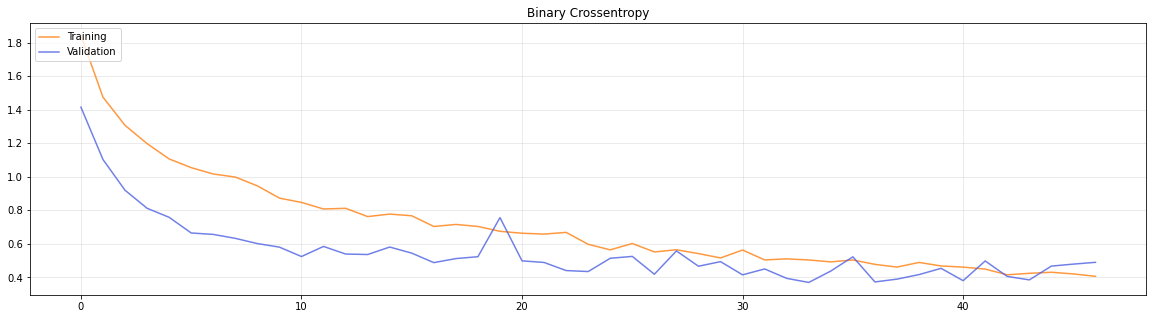

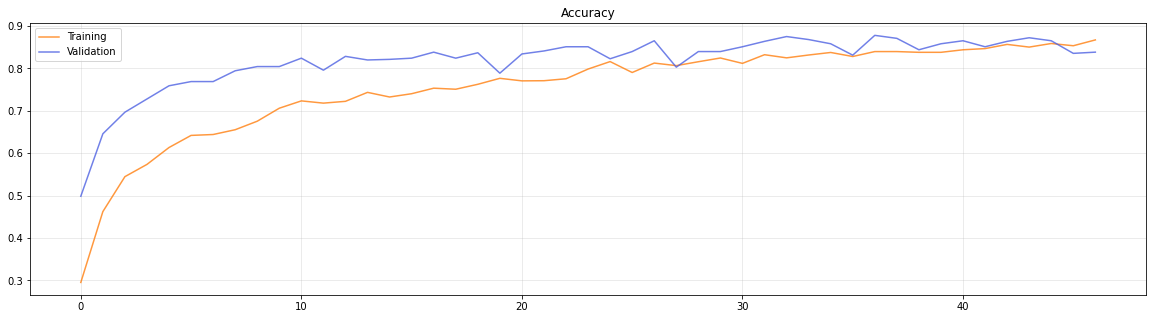

In [20]:
# Plot training history
plot_acc_loss(effnet_history_1)

### Model editing

In [21]:
# Use the supernet with the fine-tuned weights only as feature extractor
effnet_model.get_layer('efficientnetb7').trainable = False

# Recompile the model
effnet_model = compile_model(effnet_model, lr)

effnet_model.summary()

Model: "effnet_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 96, 96, 3)]       0         
_________________________________________________________________
efficientnetb7 (Functional)  (None, 3, 3, 2560)        64097687  
_________________________________________________________________
GAP (GlobalAveragePooling2D) (None, 2560)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2560)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               655616    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)              

### Second training

In [22]:
# Train the classifier on non-augmented training data
effnet_history_2 = effnet_model.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = define_callbacks(),
).history

Epoch 1/200
355/355 [==============================] - 41s 69ms/step - loss: 0.1889 - accuracy: 0.9365 - val_loss: 0.3407 - val_accuracy: 0.8924
Epoch 2/200
355/355 [==============================] - 20s 56ms/step - loss: 0.1403 - accuracy: 0.9517 - val_loss: 0.3417 - val_accuracy: 0.8994
Epoch 3/200
355/355 [==============================] - 20s 57ms/step - loss: 0.1163 - accuracy: 0.9573 - val_loss: 0.3352 - val_accuracy: 0.9008
Epoch 4/200
355/355 [==============================] - 20s 56ms/step - loss: 0.1148 - accuracy: 0.9633 - val_loss: 0.3378 - val_accuracy: 0.8980
Epoch 5/200
355/355 [==============================] - 20s 55ms/step - loss: 0.1121 - accuracy: 0.9637 - val_loss: 0.3442 - val_accuracy: 0.8980
Epoch 6/200
355/355 [==============================] - 20s 57ms/step - loss: 0.0980 - accuracy: 0.9672 - val_loss: 0.3425 - val_accuracy: 0.9037
Epoch 7/200
355/355 [==============================] - 20s 56ms/step - loss: 0.0992 - accuracy: 0.9676 - val_loss: 0.3415 - val_ac

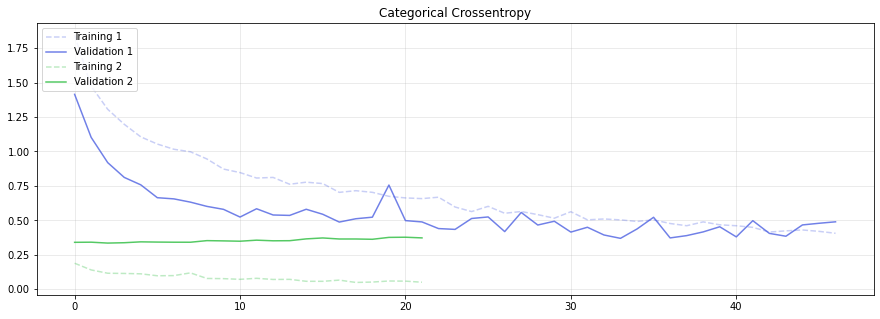

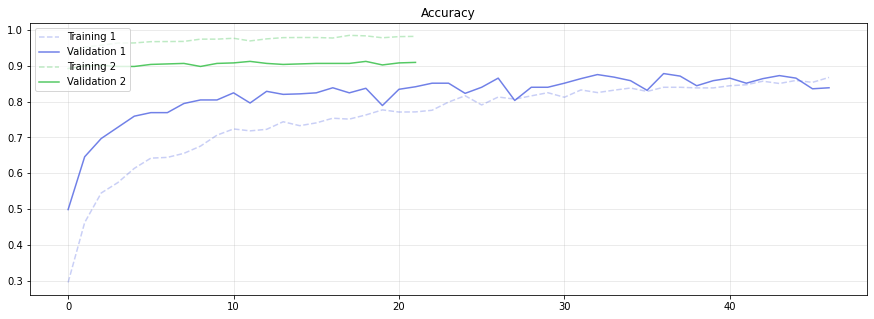

In [23]:
# Plot training history
plot_double_acc_loss(effnet_history_1, effnet_history_2)

### Performance

In [24]:
# Evaluate the performance scores for the model on the validation dataset 
evaluate_classes_performance(effnet_model, valid_gen)

              precision    recall  f1-score   support

           0       0.72      0.57      0.64        37
           1       0.92      0.92      0.92       106
           2       0.94      0.97      0.96       103
           3       0.95      0.91      0.93       102
           4       0.90      0.95      0.93       106
           5       0.91      0.93      0.92        44
           6       0.95      0.98      0.97       107
           7       0.85      0.85      0.85       101

    accuracy                           0.91       706
   macro avg       0.89      0.89      0.89       706
weighted avg       0.91      0.91      0.91       706



### Save

In [25]:
effnet_model.save('EfficientNet')

2022-11-28 00:42:58.199500: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# DenseNet Model

### Model creation

In [27]:
dense_model = build_model(
    tfk.applications.DenseNet201,
    dense_freeze,
    tfk.applications.densenet.preprocess_input,
    'densenet_model',
)

74850304/74836368 [==============================] - 0s 0us/step


In [28]:
dense_model.summary()

Model: "densenet_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 96, 96, 3)]       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 96, 96, 3)         0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 96, 96, 3)         0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 96, 96, 3)         0         
_________________________________________________________________
densenet201 (Functional)     (None, 3, 3, 1920)        18321984  
_________________________________________________________________
GAP (GlobalAveragePooling2D) (None, 1920)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1920)           

### First training

In [32]:
# Fine tune the model
dense_history_1 = dense_model.fit(
    x = aug_train_gen,
    validation_data = valid_gen,
    epochs = epochs,
    callbacks = define_callbacks(),
).history

Epoch 1/200
355/355 [==============================] - 65s 128ms/step - loss: 1.9703 - accuracy: 0.2994 - val_loss: 1.5552 - val_accuracy: 0.4178
Epoch 2/200
355/355 [==============================] - 41s 116ms/step - loss: 1.5476 - accuracy: 0.4415 - val_loss: 1.1865 - val_accuracy: 0.5666
Epoch 3/200
355/355 [==============================] - 41s 115ms/step - loss: 1.3801 - accuracy: 0.5106 - val_loss: 0.9685 - val_accuracy: 0.6884
Epoch 4/200
355/355 [==============================] - 40s 113ms/step - loss: 1.2709 - accuracy: 0.5462 - val_loss: 0.8212 - val_accuracy: 0.7210
Epoch 5/200
355/355 [==============================] - 42s 119ms/step - loss: 1.2288 - accuracy: 0.5836 - val_loss: 0.7930 - val_accuracy: 0.7195
Epoch 6/200
355/355 [==============================] - 41s 116ms/step - loss: 1.1426 - accuracy: 0.6090 - val_loss: 0.8531 - val_accuracy: 0.7266
Epoch 7/200
355/355 [==============================] - 41s 114ms/step - loss: 1.1125 - accuracy: 0.6192 - val_loss: 0.8178 -

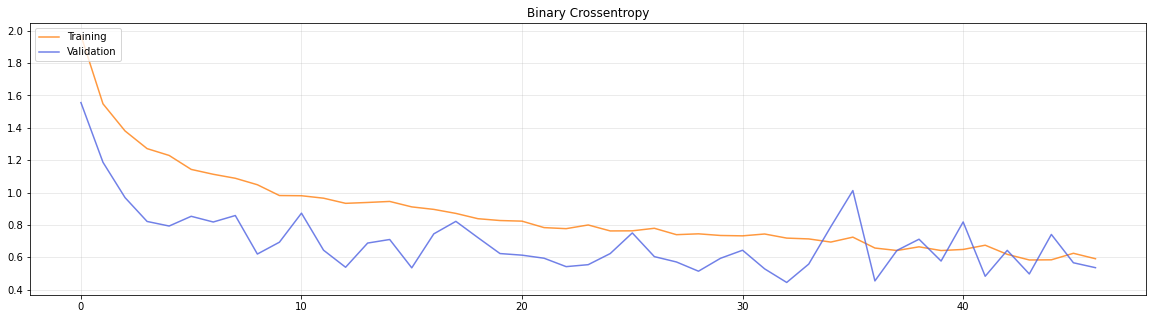

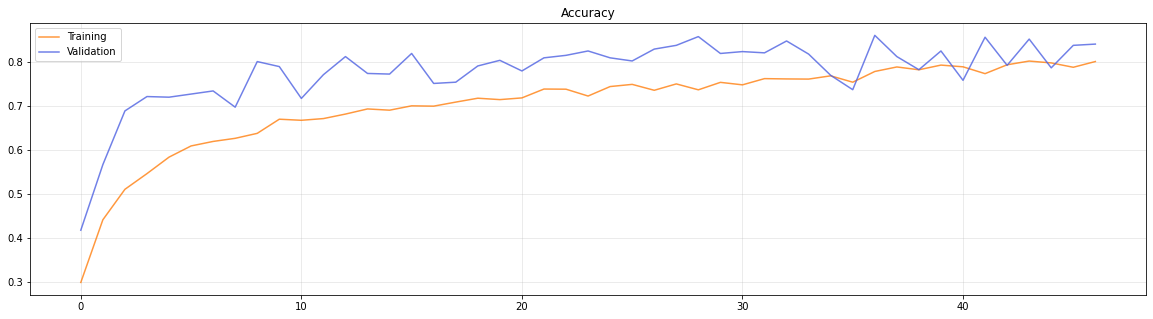

In [33]:
# Plot training history
plot_acc_loss(dense_history_1)

### Model editing

In [34]:
# Use the supernet with the fine-tuned weights only as feature extractor
dense_model.get_layer('densenet201').trainable = False

# Recompile the model
dense_model = compile_model(dense_model, lr)

dense_model.summary()

Model: "densenet_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 96, 96, 3)]       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 96, 96, 3)         0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 96, 96, 3)         0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 96, 96, 3)         0         
_________________________________________________________________
densenet201 (Functional)     (None, 3, 3, 1920)        18321984  
_________________________________________________________________
GAP (GlobalAveragePooling2D) (None, 1920)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1920)           

### Second training

In [35]:
# Train the classifier on non-augmented training data
dense_history_2 = dense_model.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = define_callbacks(),
).history

Epoch 1/200
355/355 [==============================] - 28s 53ms/step - loss: 0.2696 - accuracy: 0.9016 - val_loss: 0.4002 - val_accuracy: 0.8824
Epoch 2/200
355/355 [==============================] - 16s 46ms/step - loss: 0.2226 - accuracy: 0.9267 - val_loss: 0.4015 - val_accuracy: 0.8839
Epoch 3/200
355/355 [==============================] - 16s 44ms/step - loss: 0.2136 - accuracy: 0.9242 - val_loss: 0.3885 - val_accuracy: 0.8938
Epoch 4/200
355/355 [==============================] - 16s 46ms/step - loss: 0.2028 - accuracy: 0.9270 - val_loss: 0.4065 - val_accuracy: 0.8867
Epoch 5/200
355/355 [==============================] - 16s 44ms/step - loss: 0.1883 - accuracy: 0.9348 - val_loss: 0.3960 - val_accuracy: 0.8909
Epoch 6/200
355/355 [==============================] - 16s 46ms/step - loss: 0.1940 - accuracy: 0.9319 - val_loss: 0.4005 - val_accuracy: 0.8824
Epoch 7/200
355/355 [==============================] - 16s 44ms/step - loss: 0.1688 - accuracy: 0.9394 - val_loss: 0.4007 - val_ac

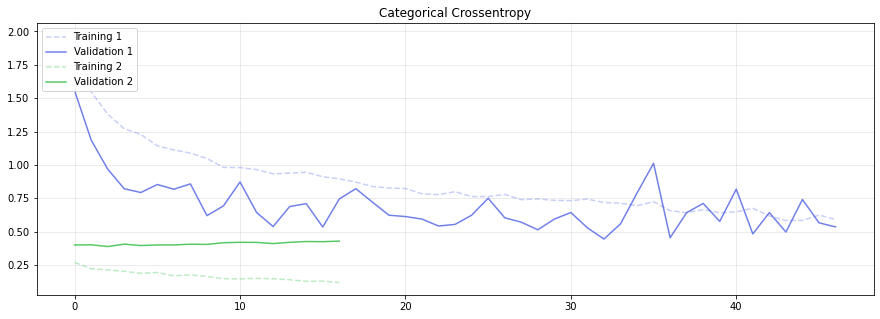

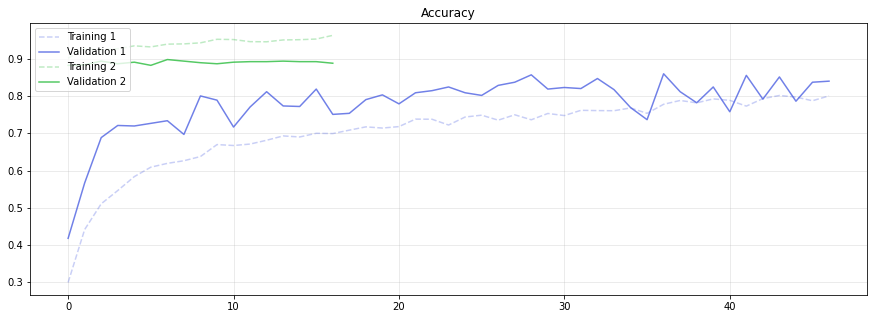

In [36]:
# Plot training history
plot_double_acc_loss(dense_history_1, dense_history_2)

### Performance

In [37]:
# Evaluate the performance scores for the model on the validation dataset 
evaluate_classes_performance(dense_model, valid_gen)

              precision    recall  f1-score   support

           0       0.62      0.49      0.55        37
           1       0.92      0.95      0.94       106
           2       0.95      0.98      0.97       103
           3       0.89      0.92      0.90       102
           4       0.93      0.90      0.91       106
           5       0.91      0.93      0.92        44
           6       0.97      0.96      0.97       107
           7       0.79      0.80      0.80       101

    accuracy                           0.90       706
   macro avg       0.87      0.87      0.87       706
weighted avg       0.90      0.90      0.90       706



### Save

In [38]:
dense_model.save('DenseNet')

In [39]:
import shutil
shutil.make_archive("DenseNet", 'zip', '/kaggle/working/DenseNet')

'/kaggle/working/DenseNet.zip'

# ConvNeXt Model

### Model building

In [26]:
convnext_model = build_model(
    tfk.applications.ConvNeXtTiny,
    convnext_freeze,
    tfk.applications.convnext.preprocess_input,
    'convnext_model',
)

In [27]:
convnext_model.summary()

Model: "convnext_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 convnext_tiny (Functional)  (None, 3, 3, 768)         27820128  
                                                                 
 GAP (GlobalAveragePooling2D  (None, 768)              0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 768)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               196864    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                    

### First training

In [28]:
# Fine tune the model
convnext_history_1 = convnext_model.fit(
    x = aug_train_gen,
    validation_data = valid_gen,
    epochs = epochs,
    callbacks = define_callbacks(),
).history

Epoch 1/200


2022-11-28 18:03:33.277725: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x2289e70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-11-28 18:03:33.277759: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2022-11-28 18:03:33.392665: W tensorflow/compiler/xla/service/gpu/nvptx_helper.cc:56] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  /usr/local/cuda-11.2
  /usr/local/cuda
  .
You can choose the search directory by setting xla_gpu_cuda_data_dir in HloModule's DebugOptions.  For most apps, setting the environment variable XLA_FLAGS=--xla_gpu_cuda_data_dir=/path/to/cuda will work.
2022-11-28 18:03:33.479078: I tensorflow/compiler/jit/xla_compilation_cache.cc:47

355/355 [==============================] - 45s 101ms/step - loss: 1.9939 - accuracy: 0.3124 - val_loss: 1.3161 - val_accuracy: 0.4901
Epoch 2/200
355/355 [==============================] - 32s 89ms/step - loss: 1.2804 - accuracy: 0.5596 - val_loss: 0.9505 - val_accuracy: 0.6671
Epoch 3/200
355/355 [==============================] - 30s 86ms/step - loss: 0.9874 - accuracy: 0.6770 - val_loss: 0.6450 - val_accuracy: 0.7720
Epoch 4/200
355/355 [==============================] - 31s 86ms/step - loss: 0.8335 - accuracy: 0.7176 - val_loss: 0.6476 - val_accuracy: 0.7875
Epoch 5/200
355/355 [==============================] - 30s 85ms/step - loss: 0.7256 - accuracy: 0.7595 - val_loss: 0.6649 - val_accuracy: 0.7649
Epoch 6/200
355/355 [==============================] - 31s 89ms/step - loss: 0.6533 - accuracy: 0.7842 - val_loss: 0.5837 - val_accuracy: 0.7833
Epoch 7/200
355/355 [==============================] - 30s 85ms/step - loss: 0.6301 - accuracy: 0.7987 - val_loss: 0.5390 - val_accuracy: 0.8

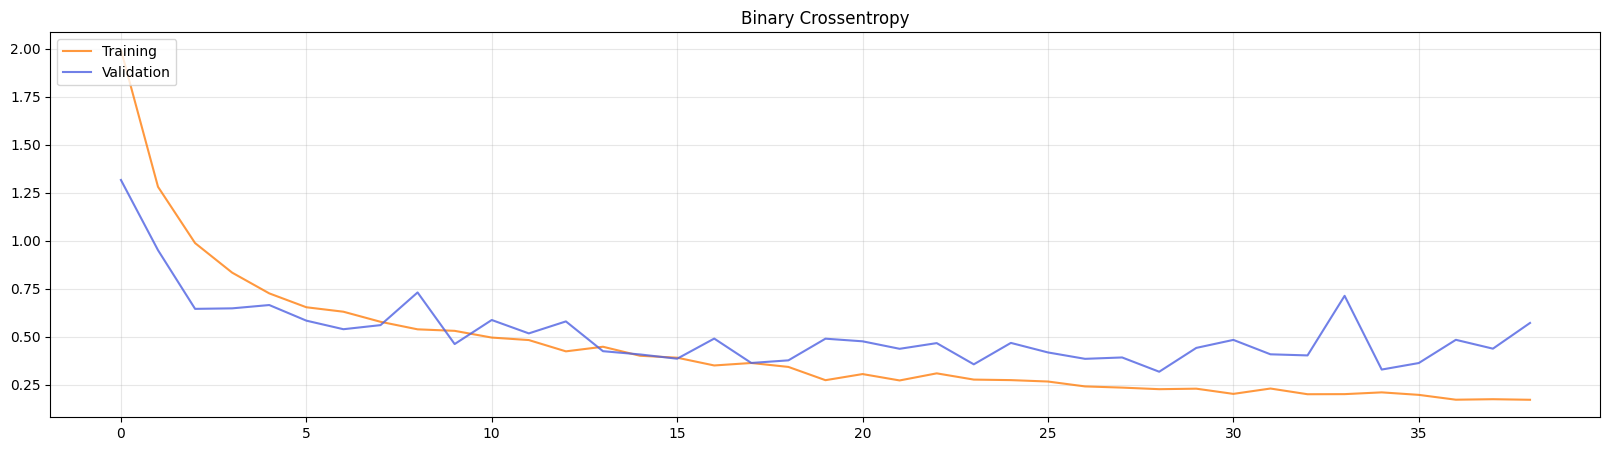

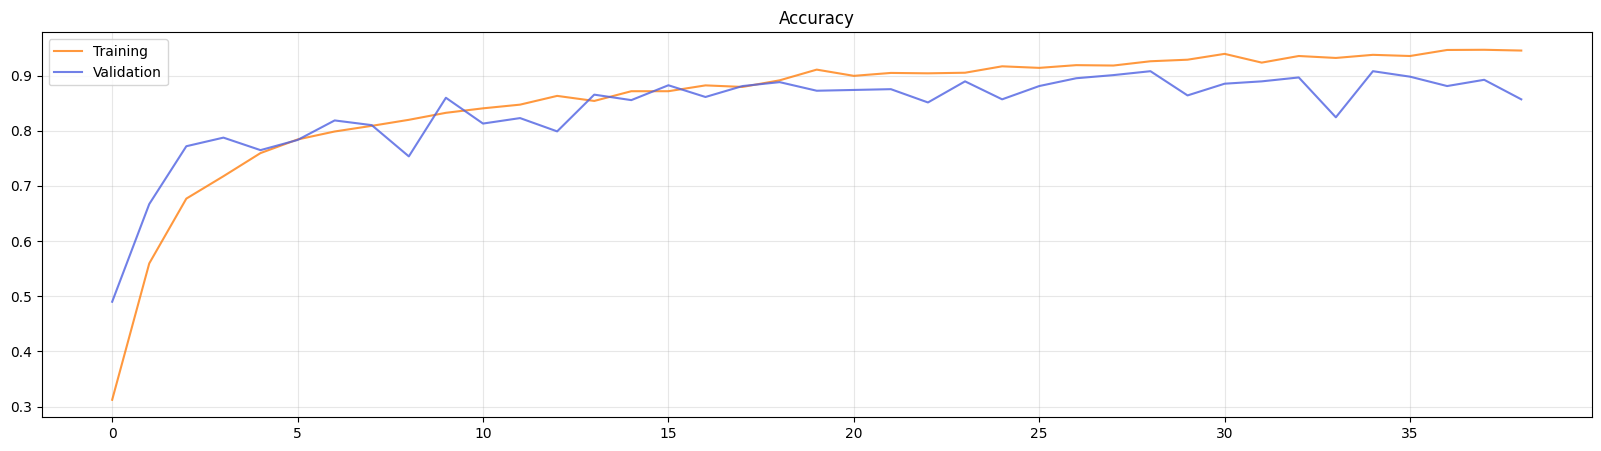

In [29]:
# Plot training history
plot_acc_loss(convnext_history_1)

### Model editing

In [30]:
# Use the supernet with the fine-tuned weights only as feature extractor
convnext_model.get_layer('convnext_tiny').trainable = False

# Recompile the model
convnext_model = compile_model(convnext_model, lr)

convnext_model.summary()

Model: "convnext_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 convnext_tiny (Functional)  (None, 3, 3, 768)         27820128  
                                                                 
 GAP (GlobalAveragePooling2D  (None, 768)              0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 768)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               196864    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                    

### Second training

In [31]:
# Train the classifier on non-augmented training data
convnext_history_2 = convnext_model.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = define_callbacks(),
).history

Epoch 1/200
355/355 [==============================] - 22s 43ms/step - loss: 0.0720 - accuracy: 0.9767 - val_loss: 0.2954 - val_accuracy: 0.9221
Epoch 2/200
355/355 [==============================] - 14s 39ms/step - loss: 0.0510 - accuracy: 0.9827 - val_loss: 0.3087 - val_accuracy: 0.9249
Epoch 3/200
355/355 [==============================] - 14s 39ms/step - loss: 0.0409 - accuracy: 0.9848 - val_loss: 0.3244 - val_accuracy: 0.9278
Epoch 4/200
355/355 [==============================] - 13s 36ms/step - loss: 0.0342 - accuracy: 0.9894 - val_loss: 0.3442 - val_accuracy: 0.9306
Epoch 5/200
355/355 [==============================] - 12s 35ms/step - loss: 0.0286 - accuracy: 0.9905 - val_loss: 0.3536 - val_accuracy: 0.9278
Epoch 6/200
355/355 [==============================] - 12s 35ms/step - loss: 0.0303 - accuracy: 0.9884 - val_loss: 0.3667 - val_accuracy: 0.9263
Epoch 7/200
355/355 [==============================] - 12s 35ms/step - loss: 0.0284 - accuracy: 0.9915 - val_loss: 0.3817 - val_ac

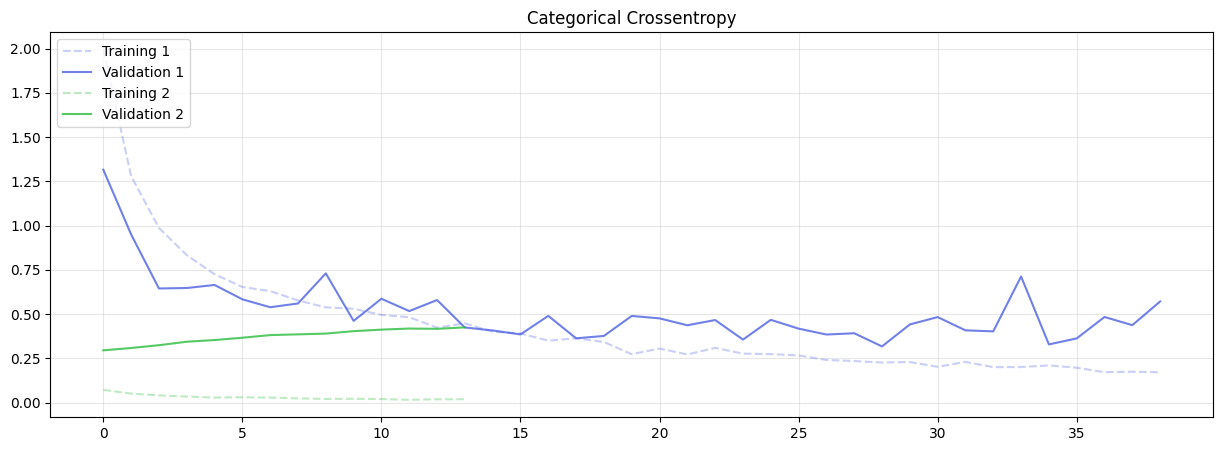

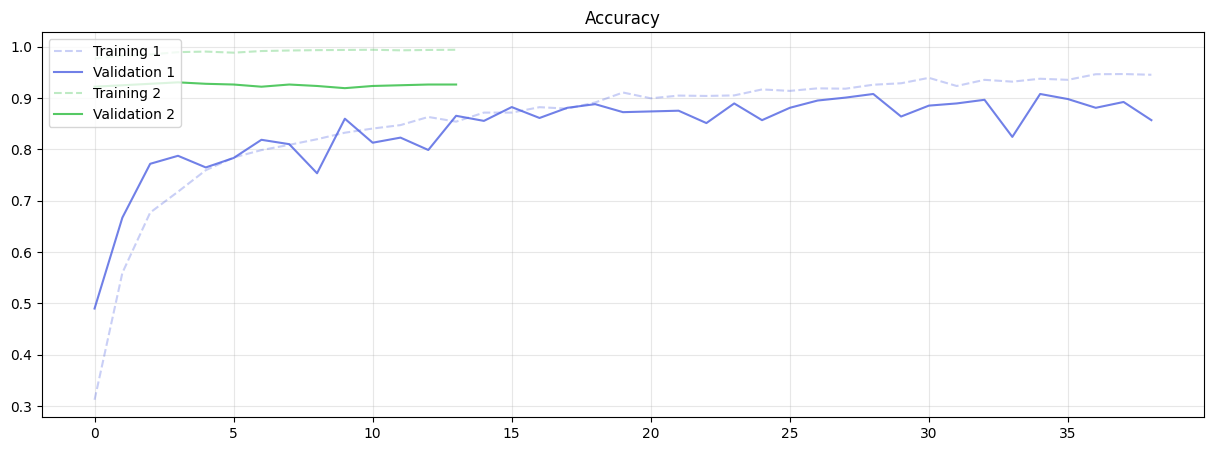

In [32]:
# Plot training history
plot_double_acc_loss(convnext_history_1, convnext_history_2)

### Performance

In [33]:
# Evaluate the performance scores for the model on the validation dataset 
evaluate_classes_performance(convnext_model, valid_gen)

23/23 [==============================] - 4s 81ms/step
              precision    recall  f1-score   support

           0       0.69      0.59      0.64        37
           1       0.98      0.94      0.96       106
           2       0.97      0.99      0.98       103
           3       0.95      0.90      0.92       102
           4       0.93      0.94      0.94       106
           5       0.91      0.93      0.92        44
           6       0.97      1.00      0.99       107
           7       0.86      0.92      0.89       101

    accuracy                           0.93       706
   macro avg       0.91      0.90      0.91       706
weighted avg       0.93      0.93      0.93       706



### Save

In [35]:
convnext_model.save('ConvNeXt')

INFO:tensorflow:Assets written to: ConvNeXt/assets


INFO:tensorflow:Assets written to: ConvNeXt/assets


# Ensemble Model

### Loading the submodels

In [36]:
def load_all_models(model_names):
    all_models = []
    for model_name in model_names:
        filename = os.path.join(submodels_dir, model_name)
        model = tfk.models.load_model(filename)
        all_models.append(model)
        print('Successfully loaded submodule:', filename)
        evaluate_classes_performance(model, valid_gen)
    return all_models

In [ ]:
# Loading the submodels from existing saves
#submodels = load_all_models(model_names)

# Loading the submodels from in-notebook trained models
submodels = [effnet_model, dense_model, convnext_model]

In [41]:
# Standardize model names and make them non-trainable
for i, model in enumerate(submodels):
    model._name = f"model_{i}"
    for layer in model.layers:
        layer.trainable = False

### Build ensemble model

In [42]:
# Common input layer
input_layer = tfk.Input(shape=input_shape)
# Disaggregated submodel outputs
submodel_outputs = [model(input_layer) for model in submodels]
# Aggregate submodel outputs by concatenation
x = tfkl.concatenate(submodel_outputs)
# Hidden layer
x = tfkl.Dense(
    10, 
    activation='relu',
    kernel_initializer = tfk.initializers.HeUniform(seed),
    name='hidden_dense',
)(x)
# Output layer
ensemble_output = tfkl.Dense(
    8, 
    activation='softmax', 
    kernel_initializer = tfk.initializers.GlorotUniform(seed),
    name='ensemble_output',
)(x)
# Create and compile ensemble model
ens_model = tfk.Model(inputs=input_layer, outputs=ensemble_output, name='ens_model')
ens_model = compile_model(ens_model, learning_rate=1e-3)

In [43]:
ens_model.summary()

Model: "ens_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 model_0 (Functional)           (None, 8)            64821151    ['input_3[0][0]']                
                                                                                                  
 model_1 (Functional)           (None, 8)            18881608    ['input_3[0][0]']                
                                                                                                  
 model_2 (Functional)           (None, 8)            28084840    ['input_3[0][0]']                
                                                                                          

### Ensemble training

In [44]:
ens_history = ens_model.fit(
    x=aug_train_gen,
    epochs=epochs, 
    validation_data=valid_gen,
    callbacks = define_callbacks(),
).history

Epoch 1/200


2022-11-28 16:46:04.404789: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.22GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-11-28 16:46:04.415302: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.31GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-11-28 16:46:04.488817: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.36GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-11-28 16:46:04.508749: W tensorflow/core/common_runtime/bfc_allocato

338/355 [===========================>..] - ETA: 2s - loss: 1.6739 - accuracy: 0.4856

2022-11-28 16:46:46.777952: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.20GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-11-28 16:46:46.788696: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


355/355 [==============================] - 97s 178ms/step - loss: 1.6467 - accuracy: 0.5025 - val_loss: 1.0142 - val_accuracy: 0.8966
Epoch 2/200
355/355 [==============================] - 52s 147ms/step - loss: 0.6998 - accuracy: 0.8903 - val_loss: 0.4270 - val_accuracy: 0.9023
Epoch 3/200
355/355 [==============================] - 50s 142ms/step - loss: 0.3565 - accuracy: 0.9073 - val_loss: 0.3124 - val_accuracy: 0.9108
Epoch 4/200
355/355 [==============================] - 50s 142ms/step - loss: 0.2661 - accuracy: 0.9323 - val_loss: 0.2784 - val_accuracy: 0.9207
Epoch 5/200
355/355 [==============================] - 51s 142ms/step - loss: 0.2363 - accuracy: 0.9379 - val_loss: 0.2729 - val_accuracy: 0.9221
Epoch 6/200
355/355 [==============================] - 50s 141ms/step - loss: 0.2243 - accuracy: 0.9390 - val_loss: 0.2825 - val_accuracy: 0.9207
Epoch 7/200
355/355 [==============================] - 50s 141ms/step - loss: 0.2192 - accuracy: 0.9394 - val_loss: 0.2860 - val_accurac

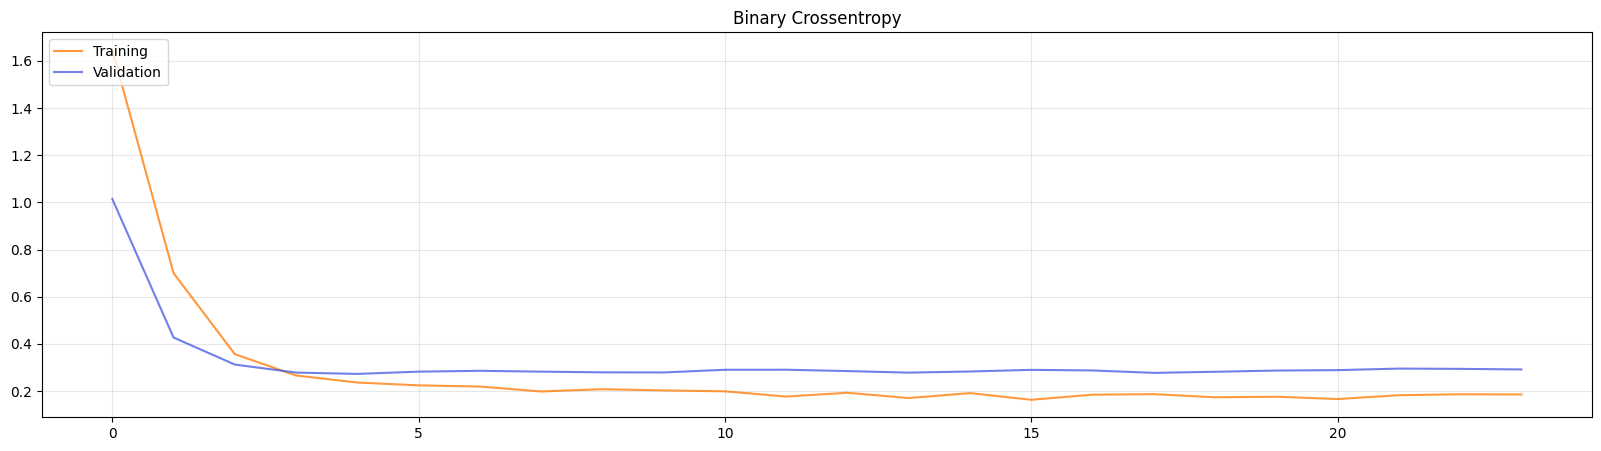

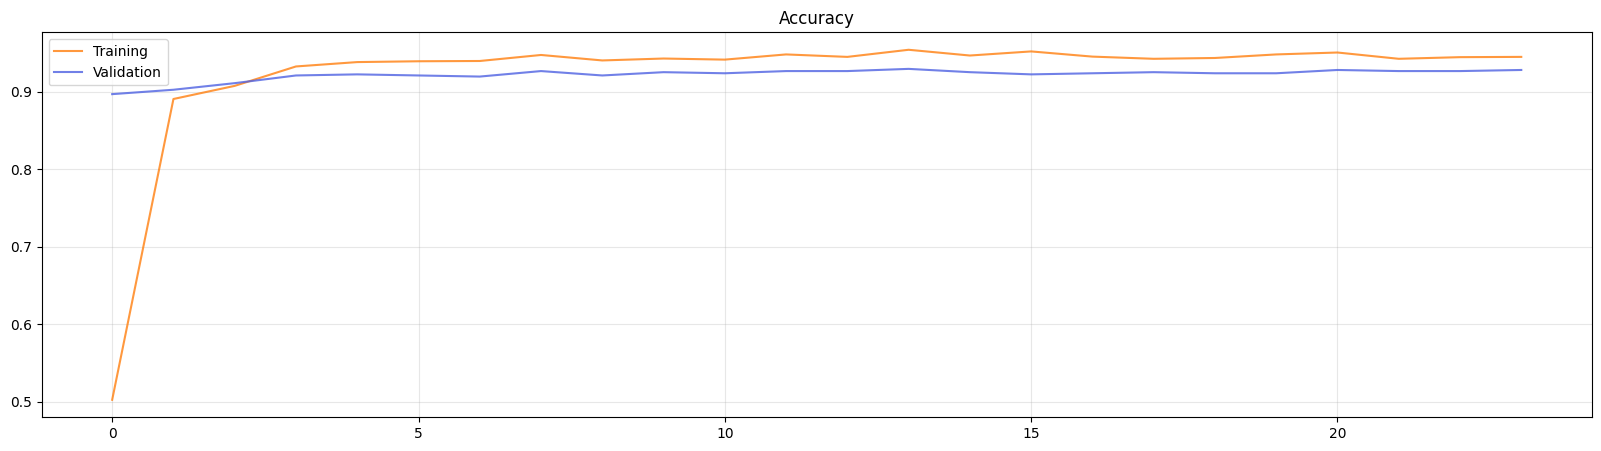

In [45]:
# Plot the training
plot_acc_loss(ens_history) 

### Performance

In [46]:
evaluate_classes_performance(ens_model, valid_gen)

23/23 [==============================] - 13s 263ms/step
              precision    recall  f1-score   support

           0       0.88      0.57      0.69        37
           1       0.89      0.98      0.93       106
           2       0.94      0.97      0.96       103
           3       0.92      0.95      0.93       102
           4       0.96      0.92      0.94       106
           5       0.98      0.91      0.94        44
           6       1.00      0.98      0.99       107
           7       0.87      0.91      0.89       101

    accuracy                           0.93       706
   macro avg       0.93      0.90      0.91       706
weighted avg       0.93      0.93      0.93       706



### Save

In [47]:
ens_model.save('EnsembleModel')

INFO:tensorflow:Assets written to: EnsembleModel/assets


INFO:tensorflow:Assets written to: EnsembleModel/assets
